# 모델 저장과 복원

https://www.tensorflow.org/tutorials/keras/save_and_load

In [1]:
import tensorflow as tf
from tensorflow import keras

tf.__version__

'2.0.0'

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_labels = train_labels[:1000]
test_labels = test_labels[:1000]

train_images = train_images[:1000].reshape(-1, 28 * 28) / 255.0
test_images = test_images[:1000].reshape(-1, 28 * 28) / 255.0

In [3]:
def create_model(): # 함수 정의함
    model = tf.keras.models.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(784,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(512, activation='relu', input_shape=(784,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
  ])

    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy', # one-hot이 아님
                metrics=['accuracy'])

    return model

In [4]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


그냥 fit 쓰면, 편하고 좋다. 상속 받아도 fit 쓸 수 있긴 하다. fit 쓰면 세부적으로 다양한 조건을 못한다. 그래서 gradient tape 쓴다.

모델에 결측치 없는지 항상 체크해야 한다. 있다면 모델이 안돌아간다. 모델 체크포인트 콜백도 콜백의 한 종류이다. 잘못되면 되돌아 갈 수 있게 만드는 것이다. 주피터 노트북에서도 체크포인트가 있다. file -> revert to checkpoint로 하면 저장했던 곳으로 되돌아 갈 수 있다. 실수한 것을 만회할 수 있다. 코딩을 했는데, 돌려야 할 경우가 너무 많다. 그래서 중간중간에 다 체크포인트를 찍어 둔다. 

loss 추세를 보다가 오히려 발산하는 경우도 생긴다. 그럴 경우에는 뒤로 되돌려서 다시 훈련방식을 바꿀 수 있다. 아주 많이 쓰는 기능이다. 처음에 모델 만들 때, 체크포인트 안 쓰면 아무것도 모르는 사람이다. 

### 훈련하는 동안 체크포인트 저장하기

In [5]:
import os
import datetime
checkpoint_path = "training_1\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # 내맘대로 써도 된다. fit 할때마다 1개 나옴.
checkpoint_dir = os.path.dirname(checkpoint_path)

# 체크포인트 콜백 만들기
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)
cp_callback = tf.keras.callbacks.TensorBoard(log_dir = checkpoint_path)

file_writer = tf.summary.create_file_writer(checkpoint_path)

In [6]:
checkpoint_path

'training_1\\20191208-205359'

tf.keras.callbacks.EarlyStopping() # monitor='val_loss'라는게 있다.

save_best_only=True -> val_loss 기준으로 가장 좋은 모델만 저장한다. 가장 좋을 때, 저장할 수 있는 것이다. loss function이 어느순간 올라가는 경우에도 이렇게 활용방안을 알아야 하는 것이다. save best only 알아두면 좋다 ★★★ 나중에 쓸 때, 제일 좋은 모델만 찾을 때 간단하게 찾을 수 있다.

In [7]:
model.fit(train_images, train_labels,  epochs = 3,
          validation_data = (test_images,test_labels),
          callbacks = [cp_callback])  # 훈련 단계에 콜백을 전달합니다

Train on 1000 samples, validate on 1000 samples
Epoch 1/3
1000/1000 [==============================] - 1s 1ms/sample - loss: 1.1405 - accuracy: 0.6680 - val_loss: 0.6154 - val_accuracy: 0.7870
Epoch 2/3
1000/1000 [==============================] - 0s 163us/sample - loss: 0.3749 - accuracy: 0.8870 - val_loss: 0.4716 - val_accuracy: 0.8490
Epoch 3/3
1000/1000 [==============================] - 0s 161us/sample - loss: 0.2533 - accuracy: 0.9290 - val_loss: 0.3999 - val_accuracy: 0.8680


In [8]:
%load_ext tensorboard

In [9]:
%tensorboard --logdir 'training_01\\20191208-204706'

Reusing TensorBoard on port 6006 (pid 9512), started 0:04:59 ago. (Use '!kill 9512' to kill it.)

In [55]:
model2 = create_model()

loss, acc = model2.evaluate(test_images, test_labels, verbose = 2)
print('훈련되지 않은 모델의 정확도: {:5.2f}%'.format(100*acc))

1000/1 - 0s - loss: 2.4135 - accuracy: 0.1600
훈련되지 않은 모델의 정확도: 16.00%


이제 체크포인트에 저장된 가중치를 불러와서 다시 평가해 보자. 훈련을 따로 안시켜도 이런식으로 체크포인트를 불러와서 쓸수가 있다.

In [56]:
model2.load_weights(checkpoint_path)

loss, acc = model2.evaluate(test_images, test_labels, verbose = 2)
print('훈련되지 않은 모델의 정확도: {:5.2f}%'.format(100*acc))

1000/1 - 0s - loss: 0.5004 - accuracy: 0.8540
훈련되지 않은 모델의 정확도: 85.40%


그런데 위와 같은 방식은 파일을 계속 덮어쓴다. 다른 테크닉을  쓰자.

### 체크포인트 콜백 매개변수

에폭 당 체크포인트를 만드는 방식으로 바꿔보자.

In [57]:
# 파일 이름에 에포크 번호를 포함시킵니다(`str.format` 포맷)
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True,
    # 다섯 번째 에포크마다 가중치를 저장합니다
    period=5) # 굳이 쓰지마라. ★★★ 

model = create_model()
model.save_weights(checkpoint_path.format(epoch=0))
model.fit(train_images, train_labels,
          epochs = 50, callbacks = [cp_callback],
          validation_data = (test_images,test_labels),
          verbose=0)


Epoch 00005: saving model to training_2/cp-0005.ckpt

Epoch 00010: saving model to training_2/cp-0010.ckpt

Epoch 00015: saving model to training_2/cp-0015.ckpt

Epoch 00020: saving model to training_2/cp-0020.ckpt

Epoch 00025: saving model to training_2/cp-0025.ckpt

Epoch 00030: saving model to training_2/cp-0030.ckpt

Epoch 00035: saving model to training_2/cp-0035.ckpt

Epoch 00040: saving model to training_2/cp-0040.ckpt

Epoch 00045: saving model to training_2/cp-0045.ckpt

Epoch 00050: saving model to training_2/cp-0050.ckpt


에폭 돌은 만큼 개수가 생긴다.

그런데 이 방법은 시행착오 용으로 쓰는 것이다. 파일을 열어봤더니 안열리기 때문에, 간혹 버전에 따라서 안열리는 경우가 있기 때문에... 이렇게 모델 체크포인트는 시행착오용으로 쓰는 것이다. 모델로서 다른 곳에서 사용을 못하기 때문에. 다른 곳에 전달할 때는 좋은 방식이 아니다. 다른 프레임워크에서 쓸 수 없다. 그래서 모델 전체를 저장할 때는 다른 구조로 저장을 할 것이다.

In [58]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'training_2\\cp-0050.ckpt'

In [59]:
model= create_model()
model.load_weights(latest)
loss, acc = model.evaluate(test_images, test_labels, verbose = 2)
print("복원된 모델의 정확도: {:5.2f}%".format(100*acc))

1000/1 - 0s - loss: 0.3328 - accuracy: 0.8850
복원된 모델의 정확도: 88.50%


In [60]:
model.load_weights(checkpoint_path)
print(str(a))

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for training_2/cp-{epoch:04d}.ckpt

In [61]:
loss, acc = model.evaluate(test_images,  test_labels, verbose=2)
print("복원된 모델의 정확도: {:5.2f}%".format(100*acc))

1000/1 - 0s - loss: 0.3328 - accuracy: 0.8850
복원된 모델의 정확도: 88.50%


# 모델 전체를 저장하기

파이썬 피클링 방식으로 저장이 되어 있기 때문에, 다른 프레임워크나 버전 문제때문에 못 불러 오는 경우가 있다. 그래서 저장할 때, 범용 파일로 저장을 해보린다. 대표적인 것이 HDF5 파일이다. hierachy data format... (?) 텐서플로 js 등에서 weight를 불러올 수 있다. 뉴럴네트워크는 학습이 어렵지만, 실행은 아주 빠르다. HDF를 불러오기 위해서는 외부 라이브러리 파일을 써야 한다.

In [62]:
# !pip install -q h5py pyyaml

In [63]:
model = create_model()

model.fit(train_images, train_labels, epochs=5)

# 전체 모델을 HDF5 파일로 저장합니다
model.save('my_model.h5')

Train on 1000 samples
Epoch 1/5
1000/1000 [==============================] - 0s 378us/sample - loss: 1.1472 - accuracy: 0.6530
Epoch 2/5
1000/1000 [==============================] - 0s 95us/sample - loss: 0.4146 - accuracy: 0.8680
Epoch 3/5
1000/1000 [==============================] - 0s 96us/sample - loss: 0.2350 - accuracy: 0.9300
Epoch 4/5
1000/1000 [==============================] - 0s 94us/sample - loss: 0.1533 - accuracy: 0.9470
Epoch 5/5
1000/1000 [==============================] - 0s 110us/sample - loss: 0.0983 - accuracy: 0.9720


In [64]:
new_model = keras.models.load_model('my_model.h5')
new_model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_30 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_31 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [65]:
loss, acc = new_model.evaluate(test_images,  test_labels, verbose=2)
print("복원된 모델의 정확도: {:5.2f}%".format(100*acc))

1000/1 - 0s - loss: 0.3660 - accuracy: 0.8580
복원된 모델의 정확도: 85.80%


m = tf.keras.models.Sequential()
m.save() # save_format -> HDF5로 저장할 수 있다.

텐서플로, 케라스 쓸 때 save 다른 옵션 써서 구분할 수 있다 케라스에서 썼는데, 텐서플로로 안되는 경우도 있다. HDF 파일 쓰는게 가장 좋은 방식이다.

# 사이킷런으로 모델 저장하기

사이킷런과 케라스를 상호 연동해서 배워본다.

In [66]:
from sklearn.datasets import load_iris
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

In [67]:
data = load_iris()

사이킷에서 제공하는 너무나 매력적인 기능들이 많은데, 크로스 밸리데이션 등.. 이걸 케라스에서 사용하고 싶은데, 그래서 케라스 쪽에서 인터페이스를 만들었다. 사이킷은 base 모델을 상속받아서 하나씩 만들었는데, 이거하고 똑같은 것을 아예 케라스 자체에 포함시켰다. 

In [68]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [69]:
def create_model():
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    model = Sequential()
    model.add(Dense(64, input_shape = (4,), activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(4, activation = 'softmax'))
    
    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = 'adam',
                 metrics = ['acc'])
    return model

In [70]:
mlp_k = KerasClassifier(create_model) # 위에서 만든 인캡슐레이션 된 모델을 던진다.

이제 이걸로 모델을 학습시킬 수 있다.

In [71]:
mlp_k.fit(data.data, data.target, epochs = 5)

Train on 150 samples
Epoch 1/5
150/150 [==============================] - 0s 2ms/sample - loss: 1.8462 - acc: 0.3333
Epoch 2/5
150/150 [==============================] - 0s 113us/sample - loss: 1.3579 - acc: 0.2133
Epoch 3/5
150/150 [==============================] - 0s 113us/sample - loss: 1.1198 - acc: 0.3333
Epoch 4/5
150/150 [==============================] - 0s 106us/sample - loss: 1.0152 - acc: 0.3333
Epoch 5/5
150/150 [==============================] - 0s 100us/sample - loss: 0.9186 - acc: 0.3400


케라스 처럼 내 마음대로 구조를 잡았으면 좋겠어서

In [72]:
from sklearn.model_selection import cross_val_score

In [73]:
cross_val_score( KerasClassifier(create_model, epochs = 5), data.data, data.target, cv = 10) # estimator는 모델을 인스턴스화 한 것이다.

Train on 135 samples
Epoch 1/5
135/135 [==============================] - 0s 2ms/sample - loss: 1.2387 - acc: 0.3704
Epoch 2/5
135/135 [==============================] - 0s 125us/sample - loss: 0.9956 - acc: 0.4593
Epoch 3/5
135/135 [==============================] - 0s 118us/sample - loss: 0.8851 - acc: 0.5556
Epoch 4/5
135/135 [==============================] - 0s 126us/sample - loss: 0.7889 - acc: 0.8148
Epoch 5/5
15/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 4ms/sample - loss: 0.5576 - acc: 1.0000
Train on 135 samples
Epoch 1/5
135/135 [==============================] - 0s

array([1.        , 1.        , 0.73333335, 0.33333334, 0.        ,
       0.        , 0.33333334, 0.26666668, 0.80000001, 0.        ])

In [74]:
from sklearn.model_selection import learning_curve

In [75]:
train_size, train_score, test_score = learning_curve(KerasClassifier(create_model, epochs = 5), data.data, data.target)

Train on 10 samples
Epoch 1/5


C:\Users\white\Anaconda3\envs\tf2.0-gpu\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


10/10 [==============================] - 0s 28ms/sample - loss: 1.8052 - acc: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 0s 400us/sample - loss: 1.5796 - acc: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 0s 500us/sample - loss: 1.3812 - acc: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 0s 299us/sample - loss: 1.2022 - acc: 0.0000e+00
Epoch 5/5
10/1 [============================================================================================================================================================================================================================================================================================================] - 0s 397us/sample - loss: 0.8967 - acc: 1.0000
Train on 32 samples
Epoch 1/5
32/32 [==============================] - 0s 8ms/sample - loss: 1.8890 - acc: 0.0000e+00
Epoch 2/5
32/32 [==============================] - 0s 125us/sample - loss: 1.6380 - acc: 0.0000e+00
Epoch 3/5
32/32 [===========

Train on 77 samples
Epoch 1/5
77/77 [==============================] - 0s 3ms/sample - loss: 2.1617 - acc: 0.0000e+00
Epoch 2/5
77/77 [==============================] - 0s 142us/sample - loss: 1.5148 - acc: 0.1039
Epoch 3/5
77/77 [==============================] - 0s 142us/sample - loss: 1.1614 - acc: 0.6494
Epoch 4/5
77/77 [==============================] - 0s 142us/sample - loss: 0.9634 - acc: 0.6494
Epoch 5/5
50/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 10 samples
Epoch 1/5
10/10 [==============================] - 0s 26ms/sample - loss: 0.5468 - acc: 1.0000
Epoch 2/5
10/10 [==============================] - 0s 497us/sample - loss: 0.4534 - acc: 1.0000
Epoch 3/5
10/10 [==============================] - 0s 398us/sample - loss: 0.3730 - acc: 1.0000
Epoch 4/5
10/10 [==============================] - 0s 399us/sample - loss: 0.3045 - acc: 1.0000
Epoch 5/5
10/1 [============================================================================================================================================================================================================================================================================================================] - 0s 437us/sample - loss: 0.2008 - acc: 1.0000
Train on 32 samples
Epoch 1/5
32/32 [==============================] - 0s 7ms/sample - loss: 1.6751 - acc: 0.0000e+00
Epoch 2/5
32/32 [==============================] - 0s 119us/sample - loss: 1.4917 - acc: 0.0000e+00
Epoch 3/5
32/3

Train on 77 samples
Epoch 1/5
77/77 [==============================] - 0s 4ms/sample - loss: 2.0217 - acc: 0.0000e+00
Epoch 2/5
77/77 [==============================] - 0s 130us/sample - loss: 1.1866 - acc: 0.2468
Epoch 3/5
77/77 [==============================] - 0s 142us/sample - loss: 0.7352 - acc: 0.7922
Epoch 4/5
77/77 [==============================] - 0s 143us/sample - loss: 0.5124 - acc: 1.0000
Epoch 5/5
50/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 10 samples
Epoch 1/5
10/10 [==============================] - 0s 30ms/sample - loss: 1.5356 - acc: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 0s 399us/sample - loss: 1.3055 - acc: 0.1000
Epoch 3/5
10/10 [==============================] - 0s 299us/sample - loss: 1.0957 - acc: 1.0000
Epoch 4/5
10/10 [==============================] - 0s 299us/sample - loss: 0.9090 - acc: 1.0000
Epoch 5/5
10/1 [============================================================================================================================================================================================================================================================================================================] - 0s 495us/sample - loss: 0.6108 - acc: 1.0000
Train on 32 samples
Epoch 1/5
32/32 [==============================] - 0s 9ms/sample - loss: 1.2348 - acc: 0.0000e+00
Epoch 2/5
32/32 [==============================] - 0s 125us/sample - loss: 1.0780 - acc: 0.2500
Epoch 3/5
32/3

Train on 77 samples
Epoch 1/5
77/77 [==============================] - 1s 7ms/sample - loss: 1.2720 - acc: 0.3506
Epoch 2/5
77/77 [==============================] - 0s 155us/sample - loss: 0.9367 - acc: 0.3506
Epoch 3/5
77/77 [==============================] - 0s 142us/sample - loss: 0.7201 - acc: 0.9610
Epoch 4/5
77/77 [==============================] - 0s 130us/sample - loss: 0.5951 - acc: 0.7143
Epoch 5/5
50/1 [======================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [76]:
# !pip install sklearn_evaluation

In [77]:
import sklearn_evaluation

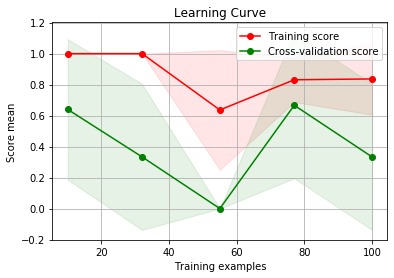

In [78]:
sklearn_evaluation.plot.learning_curve(train_score, test_score, train_size)

그래프가 요동치면, 데이터가 부족하다는 것이다. validation score가 요동친다. 그러면 학습이 잘 안되었다는 것이다. 학습이 안되는 수많은 요인들이 있다. 그 중에서 제일 먼저 해결책은 데이터 늘리는 것이다. 위의 그래프는 데이터를 x축으로 삼는 그래프라서 그렇다. 그래서 어느정도 데이터를 모아야 하냐 그러면, 위에서 나오는 것처럼 그래프를 그려보라고 하면 끝이다.

내가 어느정도 데이터가 필요한지 어떻게 아느냐? 학습되는 데이터에 따라 어떻게 성능이 바뀌는가 체크를 해봐야 한다. x축은 학습하는 데이터의 양이다. 

이처럼 사이킷런에서는 파이프라인, 그리드 서치 cv도 쓸 수 있당.

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [80]:
# 중요하다. gridsearch cv...
sc = StandardScaler()
pipe = Pipeline([('sc', sc), ('keras', KerasClassifier(create_model, epochs = 5))] )

In [81]:
pipe.fit(data.data, data.target)

Train on 150 samples
Epoch 1/5
150/150 [==============================] - 0s 2ms/sample - loss: 1.2661 - acc: 0.6200
Epoch 2/5
150/150 [==============================] - 0s 113us/sample - loss: 1.1163 - acc: 0.8267
Epoch 3/5
150/150 [==============================] - 0s 113us/sample - loss: 0.9793 - acc: 0.8333
Epoch 4/5
150/150 [==============================] - 0s 119us/sample - loss: 0.8585 - acc: 0.8333
Epoch 5/5
150/150 [==============================] - 0s 113us/sample - loss: 0.7544 - acc: 0.8333


Pipeline(memory=None,
         steps=[('sc',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('keras',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000011226F84E88>)],
         verbose=False)

# CNN 개념

https://www.tensorflow.org/tutorials/images/cnn

특징을 추출해서 특징 자체를 학습시키는 기법이다. 그래서 어떤 이미지가 들어왔을 때, 그 특징이 있으면 특정 값으로 예측을 한다. 핵심은 특징을 학습시키는 것이라고 알고 있으면 된다. 1. 특징추출 2. 예측 이렇게 2파트로 구분된다고 보면 된다.

컴볼루션 레이어를 계속 거치다 보면, 구체적인 특징에서 추상적인 특징을 잡아낸다. 추상적인 특징을 잘 잡아낼 수록 성능이 좋다고 한다. 그런데 추상적인 특징은 크기가 더 작아도 상관없다. 그 특징을 작게 잡아도, 그 특징은 유지되지만 계산복잡도는 훨씬 줄어든다. 그래서 어쩔 수 없이 크기를 줄이는 방법을 많이 사용했다. 그렇게 뽑아낸 특징으로 분류하는 것은 기계학습 알고리즘과 동일하다!

CNN이란 결국 특징을 잘 잡아주는 컨볼루션들을 찾아내는 것이다. 조심해야 할 것은 이미지가 3차원이 되어야 한다는 것이다. 뎁스가 필요하다. 3차원 연산이 필요해서 차원도 3차원이 되어야 한다. 조심할 것.

In [82]:
from tensorflow.keras import datasets, layers, models

In [93]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# 픽셀 값을 0~1 사이로 정규화합니다.
train_images, test_images = train_images / 255.0, test_images / 255.0

### 합성곱 층 만들기

특성을 뽑아낼 때, 연산복잡도 때문에 크기를 줄였었다. 그 때, 특성을 유지하는 방법을 pooling이라고 한다. 맥스 풀링은 그 중에서 가장 큰 것으로 잡아서 넣는 것이다. 뚜렷한 특성은 값이 크다. 그래서 특성 유지할 때, 가장 효율적인 방법은 맥스풀링인 것이다. 가끔 에버리지풀링을 쓰긴 하는데, 이건 논외로 한다. 맥스풀링을 쓰면, 크기는 줄여도 이미지의 고유 특징은 유지할 수 있다.

레이어에 conv1D, conv2D가 있다. 자연어처리는 conv1D를 써야해서. 그런데 우리는 이미지 처리기 때문에 conv2D를 사용할 것이다.

In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPool2D, Conv2D, Flatten, Dense

def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2))) # 속도는 빠르게 하지만, 성능은 별로 차이 x
    model.add(layers.Conv2D(64, (3, 3), activation='relu')) # 32개 특성을 세분화
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

In [67]:
model2 = models.Sequential()
# input shape가 3차원인 것에 주목
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model2.add(layers.MaxPooling2D((2, 2))) # 속도는 빠르게 하지만, 성능은 별로 차이 x
model2.add(layers.Conv2D(64, (3, 3), activation='relu')) # 32개 특성을 세분화
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))

# 전통적인 머신러닝 방법에 쓰기 위해 flatten 시킴.
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(10, activation='softmax'))

In [95]:
model = create_model()
model.summary()

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_167 (Dense)            (None, 64)              

In [98]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [100]:
model.fit(train_images, train_labels, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 6s 103us/sample - loss: 0.0162 - accuracy: 0.9947
Epoch 2/5
60000/60000 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 0.99 - 6s 93us/sample - loss: 0.0129 - accuracy: 0.9958
Epoch 3/5
60000/60000 [==============================] - 6s 93us/sample - loss: 0.0117 - accuracy: 0.9964s - los
Epoch 4/5
60000/60000 [==============================] - 6s 93us/sample - loss: 0.0091 - accuracy: 0.9970
Epoch 5/5
60000/60000 [==============================] - 6s 93us/sample - loss: 0.0086 - accuracy: 0.9974


In [102]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

10000/1 - 1s - loss: 0.0164 - accuracy: 0.9928


In [103]:
print(test_acc)

0.9928


### 컨볼루션 종류

활성화 함수에 렐루를 쓰는 이유는 오버피팅 막을려고 그런다.

In [40]:
from tensorflow.keras.layers import Conv2D, Convolution2D

Conv2D is Convolution2D # 똑같은거다.

True

feature를 잘 못뽑는다면, 레이어를 늘려서 성능을 높이는 경우도 있다. (딥) 

# 오버피팅에 관하여

딥러닝의 가장 무서운 적이 오버피팅이다. 오버피팅은 왜 생기냐? 모델이 복잡하면 복잡할 수록 잘 생긴다. 노드 개수, 깊이가 많아지면 많아질수록 오버피팅이 잘 생긴다. 노드가 많을 수록, 레이어가 많을 수록, 에폭을 많이 돌릴수록 오버피팅이 잘 생긴다. 그래서 오버피팅을 막기 위한 수많은 방법을 써야 한다.

첫번째 방법은 가장 좋은 방법은 패털티를 주는 것이다. l1, l2 패털티를 레이어에 줘서 오버피팅을 막을 수 있다. 이건 Dense에 있다. 

두번째 방법은 드롭아웃을 쓰는 것이다. 상당히 유명함! 에폭을 많이 돌릴수록 성능이 좋아지는데, 그 성능이 오버피팅 되어버린다. 그 공부를 랜덤하게 대충 못하도록 막아버린다. 모델이 너무 복잡해지는 것을 방지해버린다. 케라스에서 드랍아웃은 레이어 뒤에 추가하면 된다. 이 방법은 스테이트 머신 개념이다. matplotlib에서 나온 것이다. 이렇게 하면 공부를 많이 안하니까 오버피팅이 작게 생긴다.

세번째 방법은 얼리스탑핑

네번째는 앙상블 시켜서, 오버피팅 막을 수 있다.

---

컨볼루션의 장점

1. 공간적인 정보를 가지고 한다.
2. 에폭을 적게 돌려도 된다.

In [ ]:
Dense()